# Exploratory Data Analysis (EDA)

## Table of Contents
1. [Dataset Overview](#dataset-overview)
2. [Handling Missing Values](#handling-missing-values)
3. [Feature Distributions](#feature-distributions)
4. [Possible Biases](#possible-biases)
5. [Correlations](#correlations)


## Initial Setup

In [1]:
# libraries for dataset operations
import pandas as pd
import numpy as np

# libraries for data visualization
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns


In [2]:
# Stats models
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import kpss

# Date tools
from datetime import datetime, timedelta, date
import matplotlib.dates as mdates

In [3]:
# ignoring warnings
import warnings
warnings.filterwarnings('ignore')

In [4]:
# setting default number of rows and columns to be displayed
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)  # No limit on column width
pd.set_option('display.width', 200)  # Set a high enough width to prevent wrapping
pd.set_option('display.colheader_justify', 'center')  # Center column headers for readability

# adjusting CSS for the Jupyter Notebook, to avoid text-wrapping
from IPython.display import display, HTML
display(HTML("<style>.dataframe td { white-space: nowrap; }</style>"))

In [5]:
# number formatting for better readability

nf_0 = lambda x: f'{x:,.0f}' if isinstance(x, (int, float)) else x # rounding-off to 0 decimals with thousand separator (for integers)
nf_2 = lambda x: f'{x:,.2f}' if isinstance(x, (int, float)) else x # rounding-off to 2 decimals with thousand separator (for floats)
nf_2np = lambda x: f'{x:.2%}' if isinstance(x, (int, float)) else x # rounding-off to 2 decimals with percent sign, assuming the number is calculated as percentage and not displayed as percentage
nf_2pp = lambda x: f'{x/100:.2%}' if isinstance(x, (int, float)) else x # rounding-off to 2 decimals with percent sign, assuming the number is displayed as percentage but without percentage sign

## Dataset Overview

[Provide a high-level overview of the dataset. This should include the source of the dataset, the number of samples, the number of features, and example showing the structure of the dataset.]


In [6]:
# loading the dataset
df = pd.read_csv('https://raw.githubusercontent.com/kalakhushi18/Advance-Time-Series-Prediction-W24/refs/heads/main/dataset.csv')
# Number of samples
num_samples = df.shape[0]

# Number of features
num_features = df.shape[1]

# Display these dataset characteristics
print(f"Number of observations: {num_samples}")
print(f"Number of features: {num_features}")

# Display the first few rows of the dataframe to show the structure
print("Example data:")
print(df.head(10))


Number of observations: 3656
Number of features: 8
Example data:
      date     bitcoin_closing_prices  sp500_closing_data inflation_rate  daily_treasury_rates  bitcoin_daily_google_trends  is_holiday  twitter_sentiments_score
0  2014-11-01        325.748993                    NaN          NaN                NaN                      40                    1                NaN           
1  2014-11-02        325.891998                    NaN          NaN                NaN                      44                    1                NaN           
2  2014-11-03        327.553986            2017.810059         1.93               0.03                      46                    0                NaN           
3  2014-11-04        330.492004            2012.099976         1.92               0.04                      43                    0                NaN           
4  2014-11-05        339.485992            2023.569946         1.93               0.04                      45               

In [7]:
print(df.describe())

       bitcoin_closing_prices  sp500_closing_data  daily_treasury_rates  bitcoin_daily_google_trends  is_holiday   twitter_sentiments_score
count        3655.000000           2517.000000          2502.000000              3656.000000          3656.000000             0.0          
mean        18632.744444           3293.187358             1.628030                49.153446             0.314551             NaN          
std         20226.941042           1043.490524             1.847423                18.142972             0.464400             NaN          
min           178.102997           1829.079956            -0.040000                 9.000000             0.000000             NaN          
25%          1471.454956           2387.449951             0.090000                36.000000             0.000000             NaN          
50%          9330.549805           2964.330078             0.940000                47.000000             0.000000             NaN          
75%         30055.91

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3656 entries, 0 to 3655
Data columns (total 8 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   date                         3656 non-null   object 
 1   bitcoin_closing_prices       3655 non-null   float64
 2   sp500_closing_data           2517 non-null   float64
 3   inflation_rate               2610 non-null   object 
 4   daily_treasury_rates         2502 non-null   float64
 5   bitcoin_daily_google_trends  3656 non-null   int64  
 6   is_holiday                   3656 non-null   int64  
 7   twitter_sentiments_score     0 non-null      float64
dtypes: float64(4), int64(2), object(2)
memory usage: 228.6+ KB


In [9]:
# changing 'date' column to datetime format
df['date'] = pd.to_datetime(df['date'])

In [10]:
# replacing '.' with np.nan in 'inflation_rate' column
df['inflation_rate'] = df['inflation_rate'].replace('.', np.nan)

In [11]:
# changing the type of 'inflation_rate' column to float
df['inflation_rate'] = df['inflation_rate'].astype(float)

## Handling Missing Values

[Identify any missing values in the dataset, and describe your approach to handle them if there are any. If there are no missing values simply indicate that there are none.]


In [12]:
# Check for missing values
missing_values_count = df.isnull().sum()
missing_values_percent = (df.isnull().sum() / len(df)) * 100
missing_values_percent = missing_values_percent.map(nf_2pp)
missing_values= pd.concat([missing_values_count, missing_values_percent], axis=1)
missing_values.columns = ['Count', 'Percentage']

print("Missing values:")
print(missing_values)

Missing values:
                             Count Percentage
date                            0      0.00% 
bitcoin_closing_prices          1      0.03% 
sp500_closing_data           1139     31.15% 
inflation_rate               1154     31.56% 
daily_treasury_rates         1154     31.56% 
bitcoin_daily_google_trends     0      0.00% 
is_holiday                      0      0.00% 
twitter_sentiments_score     3656    100.00% 


<Axes: >

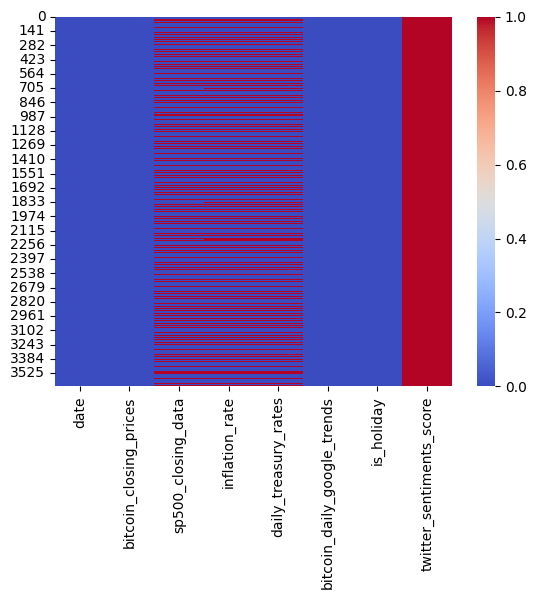

In [13]:
# heatmap of missing values
sns.heatmap(df.isnull(), cmap='coolwarm')

In [14]:
# ffilling missing values in 'sp500_closing_data', 'inflation_rate' and 'daily_treasury_rate' columns
df['sp500_closing_data'] = df['sp500_closing_data'].fillna(method='ffill')
df['inflation_rate'] = df['inflation_rate'].fillna(method='ffill')
df['daily_treasury_rates'] = df['daily_treasury_rates'].fillna(method='ffill')

In [15]:
# bfilling missing values in 'sp500_closing_data', 'inflation_rate' and 'daily_treasury_rate' columns.
# this bfill is for date 01-Nov-2014 and 02-Nov-2014 only as days on these dates are Saturday and Sunday respectively and we have no data to ffill
df['sp500_closing_data'] = df['sp500_closing_data'].fillna(method='bfill')
df['inflation_rate'] = df['inflation_rate'].fillna(method='bfill')
df['daily_treasury_rates'] = df['daily_treasury_rates'].fillna(method='bfill')

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3656 entries, 0 to 3655
Data columns (total 8 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   date                         3656 non-null   datetime64[ns]
 1   bitcoin_closing_prices       3655 non-null   float64       
 2   sp500_closing_data           3656 non-null   float64       
 3   inflation_rate               3656 non-null   float64       
 4   daily_treasury_rates         3656 non-null   float64       
 5   bitcoin_daily_google_trends  3656 non-null   int64         
 6   is_holiday                   3656 non-null   int64         
 7   twitter_sentiments_score     0 non-null      float64       
dtypes: datetime64[ns](1), float64(5), int64(2)
memory usage: 228.6 KB


In [17]:
# Check for missing values
missing_values_count = df.isnull().sum()
missing_values_percent = (df.isnull().sum() / len(df)) * 100
missing_values_percent = missing_values_percent.map(nf_2pp)
missing_values= pd.concat([missing_values_count, missing_values_percent], axis=1)
missing_values.columns = ['Count', 'Percentage']

print("Missing values:")
print(missing_values)

Missing values:
                             Count Percentage
date                            0      0.00% 
bitcoin_closing_prices          1      0.03% 
sp500_closing_data              0      0.00% 
inflation_rate                  0      0.00% 
daily_treasury_rates            0      0.00% 
bitcoin_daily_google_trends     0      0.00% 
is_holiday                      0      0.00% 
twitter_sentiments_score     3656    100.00% 


In [18]:
# checking dates where null values are present
df[df['bitcoin_closing_prices'].isnull()]

,date,bitcoin_closing_prices,sp500_closing_data,inflation_rate,daily_treasury_rates,bitcoin_daily_google_trends,is_holiday,twitter_sentiments_score
3655,2024-11-03,NaN,5728.799805,2.33,4.57,52,1,NaN


In [19]:
# dropping rows where bitcoin_closing_prices is null
df = df.dropna(subset=['bitcoin_closing_prices'])

In [20]:
# Check for missing values
missing_values_count = df.isnull().sum()
missing_values_percent = (df.isnull().sum() / len(df)) * 100
missing_values_percent = missing_values_percent.map(nf_2pp)
missing_values= pd.concat([missing_values_count, missing_values_percent], axis=1)
missing_values.columns = ['Count', 'Percentage']

print("Missing values:")
print(missing_values)

Missing values:
                             Count Percentage
date                            0      0.00% 
bitcoin_closing_prices          0      0.00% 
sp500_closing_data              0      0.00% 
inflation_rate                  0      0.00% 
daily_treasury_rates            0      0.00% 
bitcoin_daily_google_trends     0      0.00% 
is_holiday                      0      0.00% 
twitter_sentiments_score     3655    100.00% 


## Feature Distributions

[Plot the distribution of various features and target variables. Comment on the skewness, outliers, or any other observations.]


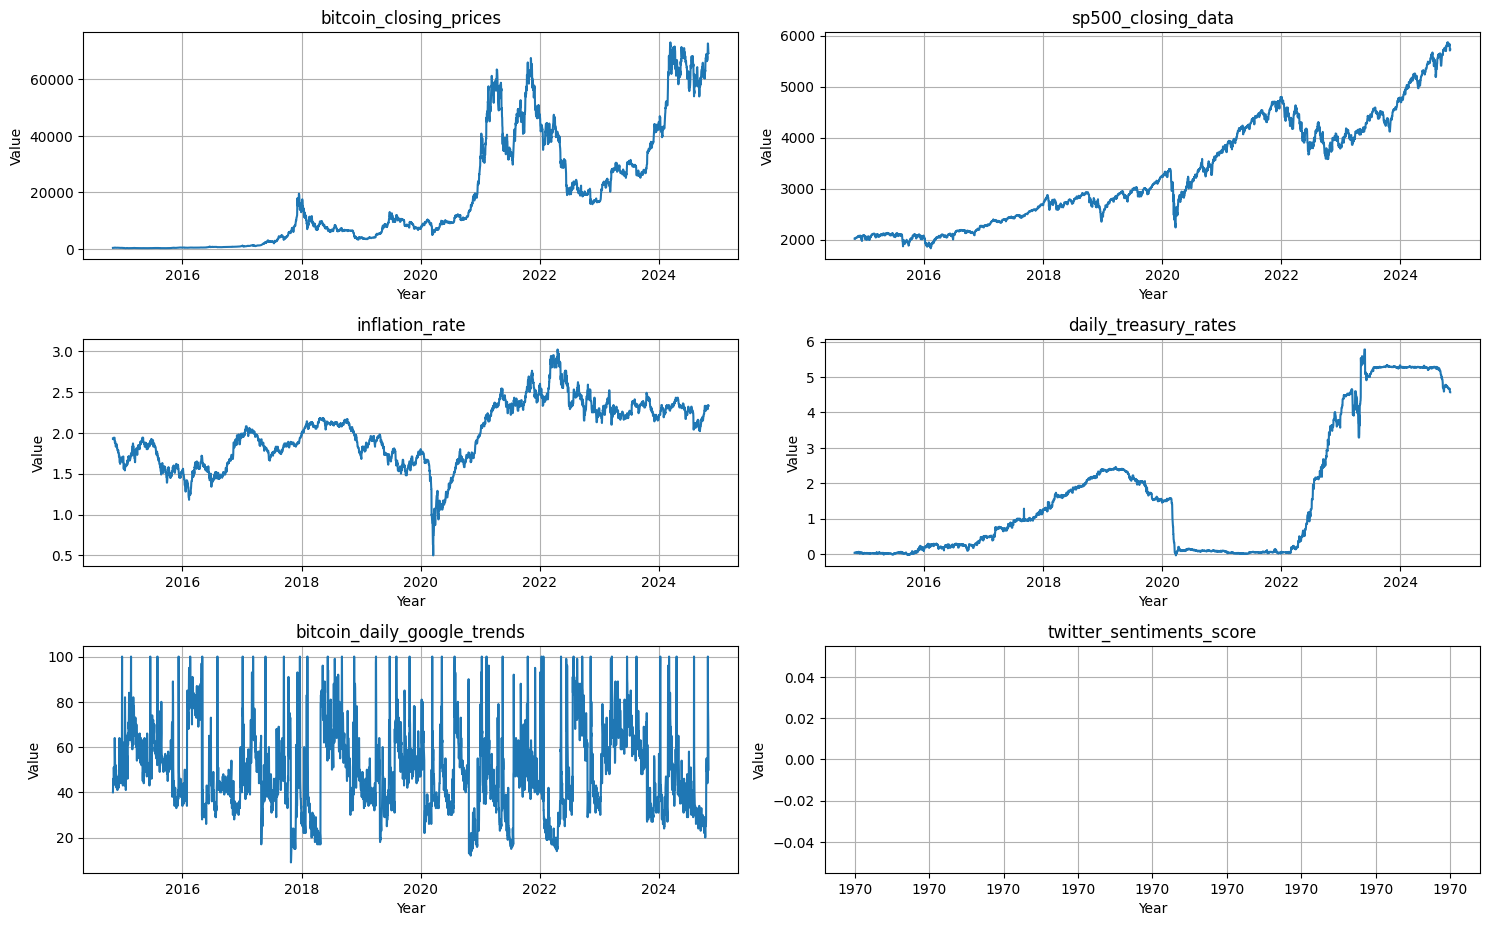

In [21]:
# Define the variables to be plotted
variables = ['bitcoin_closing_prices', 'sp500_closing_data',
             'inflation_rate', 'daily_treasury_rates',
             'bitcoin_daily_google_trends',
             'twitter_sentiments_score']

# Set up the 4x2 subplot grid
fig, axes = plt.subplots(4, 2, figsize=(15, 12), sharex=False)

# Flatten the 2D axes array for easy indexing
axes = axes.flatten()

# Format x-axis to show years
years = mdates.DateFormatter('%Y')

# Plot each variable
for i, col in enumerate(variables):
    axes[i].plot(df['date'], df[col], label=col)
    axes[i].set_title(col, fontsize=12)
    axes[i].xaxis.set_major_formatter(years)  # Set x-axis format
    axes[i].grid(True)
    axes[i].set_ylabel('Value')
    axes[i].set_xlabel('Year')

# Remove empty subplots if there are fewer than 8 variables
for j in range(len(variables), len(axes)):
    fig.delaxes(axes[j])

# Adjust layout for clarity
plt.tight_layout()
plt.show()

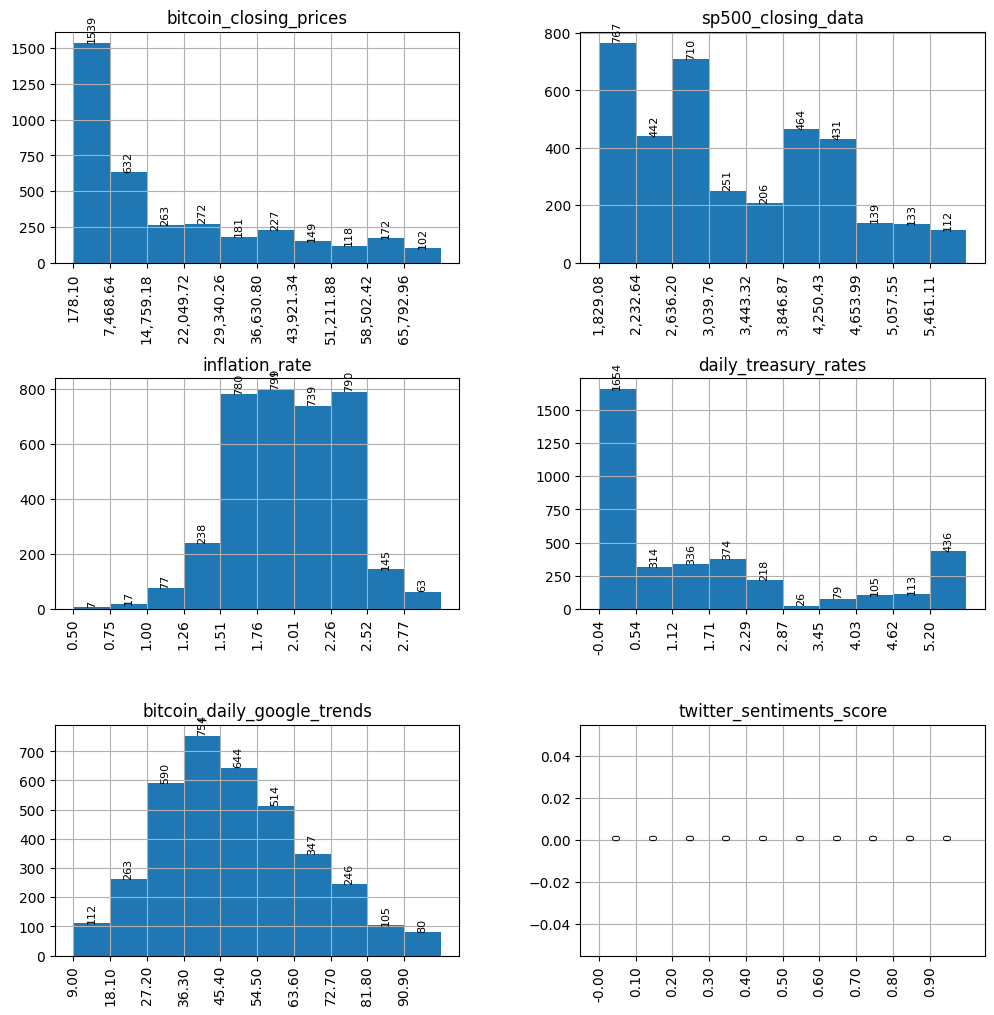

In [22]:
# Plotting histograms of all numerical features
bins=10

df[['bitcoin_closing_prices', 'sp500_closing_data', 'inflation_rate', 'daily_treasury_rates', 
    'bitcoin_daily_google_trends', 'twitter_sentiments_score']].hist(bins=bins, figsize=(12, 12))

# displaying count of values above each bar
for ax in plt.gcf().axes:
    for container in ax.containers:
        ax.bar_label(container, rotation=90, fontsize=8)
    
    # Set x-ticks for each bin (using bin edges)
    bin_edges = ax.patches[0].get_x()  # Getting the starting position of the first bin
    bin_width = ax.patches[0].get_width()  # Width of each bin
    ticks = [bin_edges + i * bin_width for i in range(bins)]  # Generate bin centers
    ax.set_xticks(ticks)  # Set ticks on x-axis
    ax.set_xticklabels([f'{tick:,.2f}' for tick in ticks], rotation=90)  # Format labels for better readability
plt.subplots_adjust(hspace=0.5, wspace=0.3)  # Increase vertical and horizontal space
plt.grid(True)
plt.show()

## Possible Biases

[Investigate the dataset for any biases that could affect the model’s performance and fairness (e.g., class imbalance, historical biases).]


In [23]:
# Import necessary library
from scipy.stats import skew

# Calculate skewness for each column and print results
for column in df[['bitcoin_closing_prices', 'sp500_closing_data', 'inflation_rate', 'daily_treasury_rates', 
    'bitcoin_daily_google_trends', 'twitter_sentiments_score']]:
    if column in df.columns:
        column_skewness = skew(df[column].dropna())  # Drop NaNs before calculating skewness
        print(f"Skewness of {column}: {column_skewness:.6f}")
    else:
        print(f"Column {column} not found in the DataFrame!")


Skewness of bitcoin_closing_prices: 1.058494
Skewness of sp500_closing_data: 0.497879
Skewness of inflation_rate: -0.121720
Skewness of daily_treasury_rates: 0.991105
Skewness of bitcoin_daily_google_trends: 0.473198
Skewness of twitter_sentiments_score: nan


In [24]:
# Example: Checking for class imbalance in a classification problem
# sns.countplot(x='target_variable', data=df)

# Your code to investigate possible biases goes here


## Correlations

[Explore correlations between features and the target variable, as well as among features themselves.]


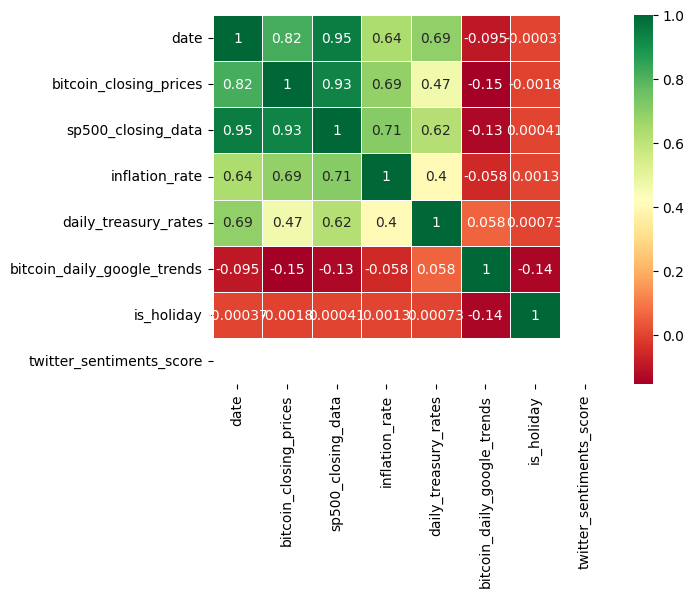

In [25]:
# Example: Plotting a heatmap to show feature correlations

corr = df.corr()
sns.heatmap(corr, cmap='RdYlGn', annot=True, linewidths=0.5)
plt.show()


In [26]:
print(corr.map(nf_2))

                             date  bitcoin_closing_prices sp500_closing_data inflation_rate daily_treasury_rates bitcoin_daily_google_trends is_holiday twitter_sentiments_score
date                          1.00           0.82                 0.95             0.64             0.69                     -0.09              -0.00              nan          
bitcoin_closing_prices        0.82           1.00                 0.93             0.69             0.47                     -0.15              -0.00              nan          
sp500_closing_data            0.95           0.93                 1.00             0.71             0.62                     -0.13               0.00              nan          
inflation_rate                0.64           0.69                 0.71             1.00             0.40                     -0.06               0.00              nan          
daily_treasury_rates          0.69           0.47                 0.62             0.40             1.00           

In [27]:
# Define the variables for plotting
variables = ['bitcoin_closing_prices', 'sp500_closing_data', 
             'inflation_rate', 'daily_treasury_rates', 
             'bitcoin_daily_google_trends']

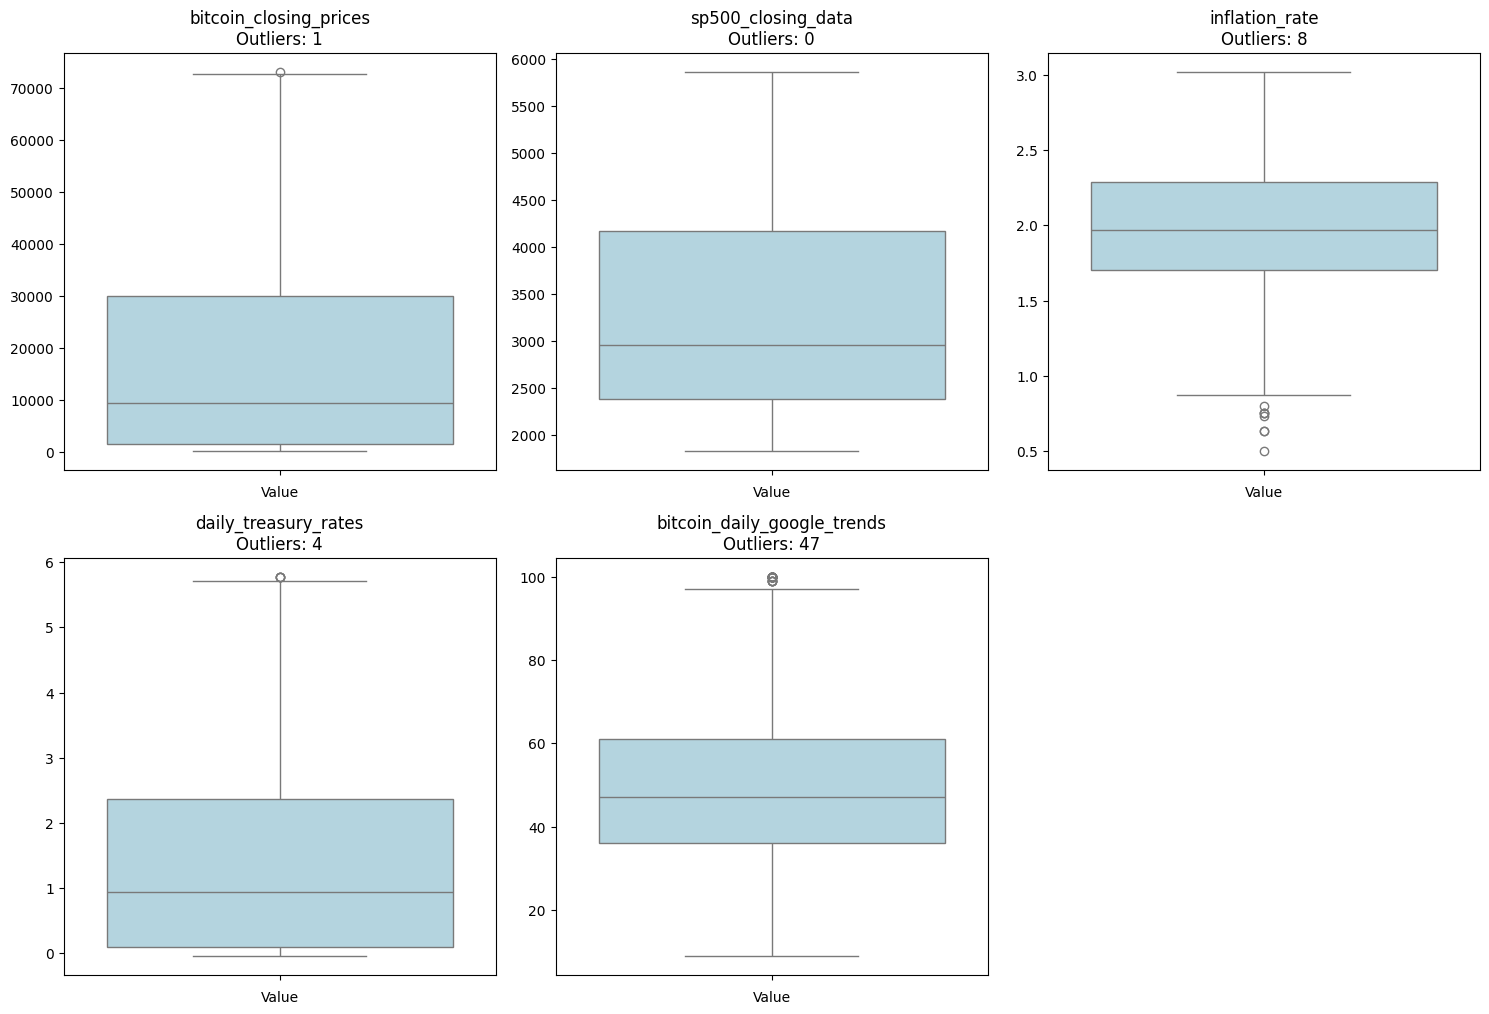

In [28]:
# Function to detect outliers using the IQR method
def detect_outliers_iqr(data):
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return ((data < lower_bound) | (data > upper_bound))

# Set up the plot grid (3x3 layout)
fig, axes = plt.subplots(3, 3, figsize=(15, 15))
axes = axes.flatten()

# Generate boxplots for each numeric column
for i, col in enumerate(variables):
    ax = axes[i]
    valid_data = df[col].dropna()  # Drop missing values
    sns.boxplot(y=valid_data, ax=ax, color='lightblue')  # Pass clean data

    # Detect and count outliers for the current column
    outliers = detect_outliers_iqr(df[col])  # Pass the individual column
    num_outliers = outliers.sum()

    # Annotate the plot with the number of outliers
    ax.set_title(f"{col}\nOutliers: {num_outliers}", fontsize=12)
    ax.set_xlabel('Value')
    ax.set_ylabel('')

# Hide unused subplots if columns < 9
for j in range(len(variables), len(axes)):
    fig.delaxes(axes[j])

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

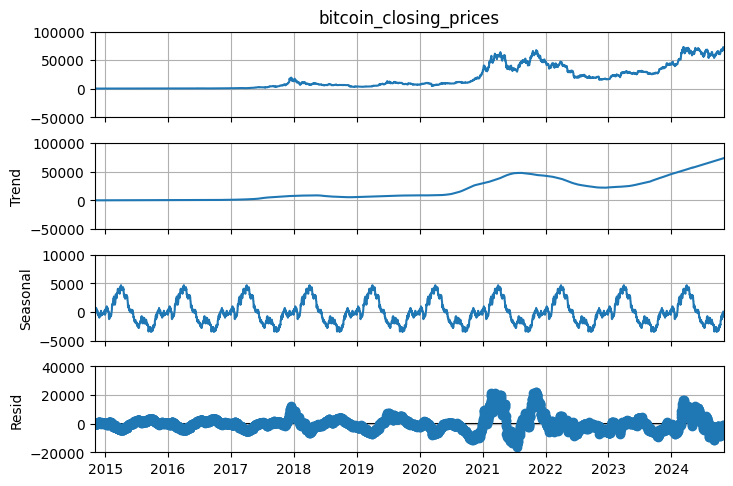

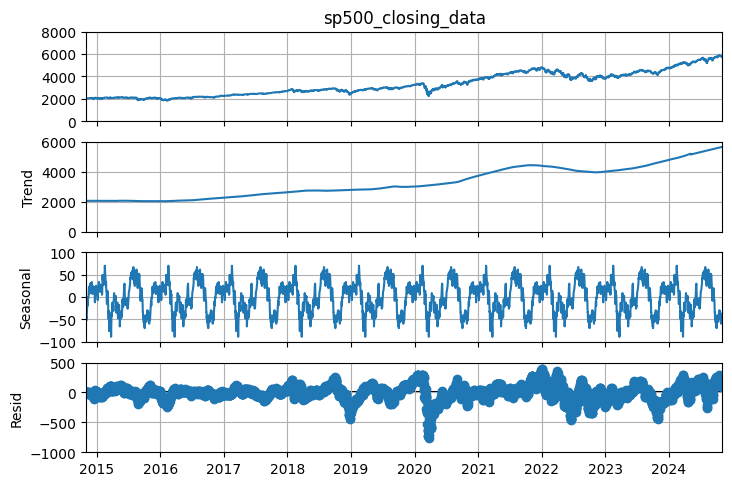

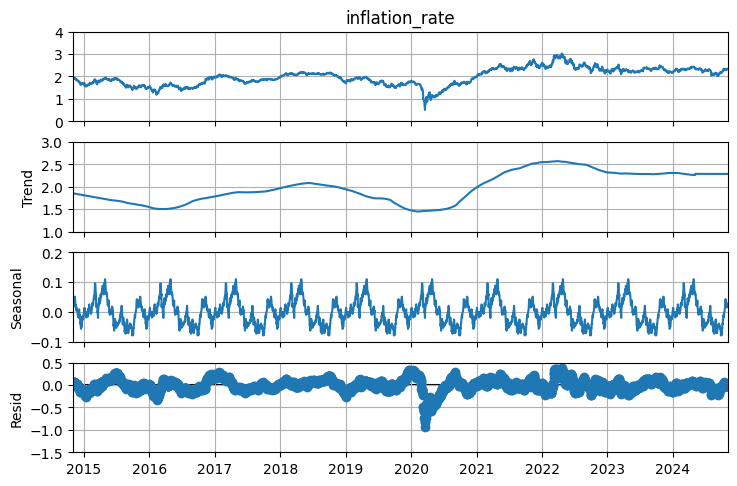

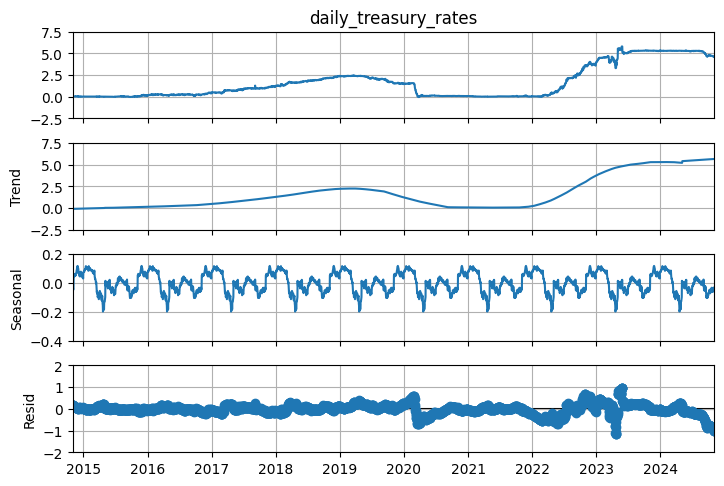

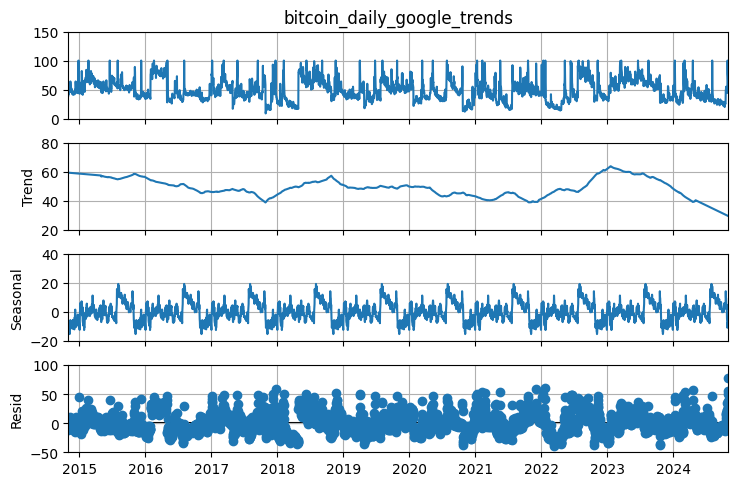

In [29]:
# Ensure 'date' is the datetime index
df.set_index('date', inplace=True)

# Specify the period (assumes daily data with yearly seasonality, adjust as needed)
period = 365

# Iterate through each column to perform seasonal decomposition
for col in variables:
    
    # Perform seasonal decomposition (additive model, as Multiplicative seasonality is not appropriate for zero and negative values)
    result = seasonal_decompose(df[col].dropna(), model='additive', period=period, extrapolate_trend='freq')
    
    # Plot the decomposition
    fig = result.plot()
    fig.set_size_inches(7.5, 5)  # Adjust figure size
    
    # Get the axes from the figure
    axes = fig.get_axes()

    # Iterate over each subplot axis (observed, trend, seasonal, residual)
    for ax in axes:
        ax.grid(True)  # Enable gridlines for all subplots
        ax.set_yticks(ax.get_yticks())  # Show y-ticks
        
# Remove empty subplots if there are fewer than 8 variables
for j in range(len(variables), len(axes)):
    fig.delaxes(axes[j])

    # Display the plot
    plt.show()

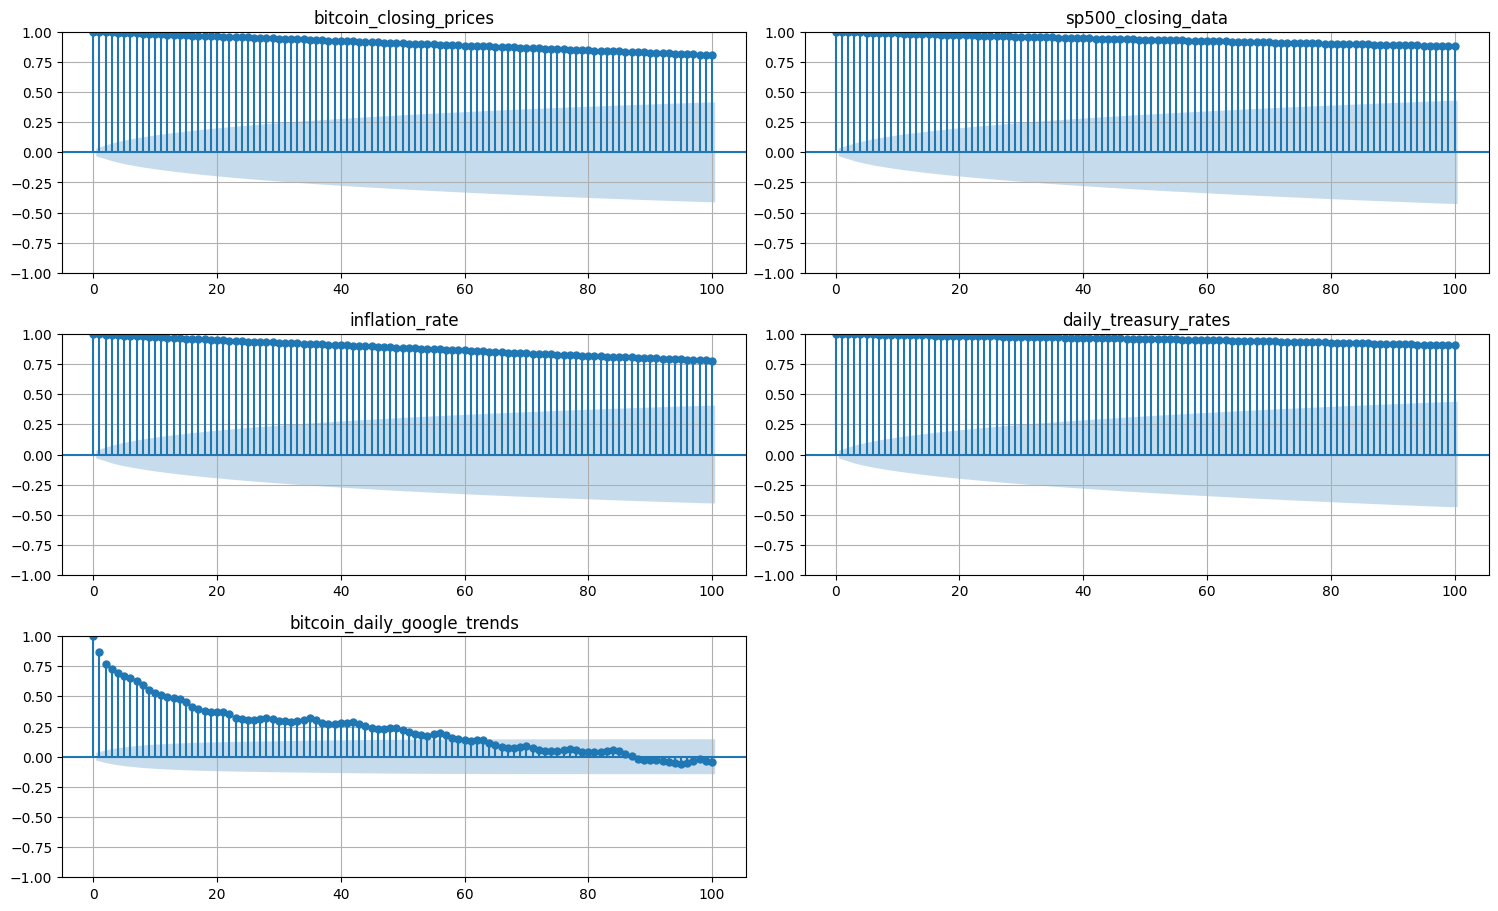

In [30]:
# Create a figure with subplots (4 rows and 2 columns for 8 variables)
fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(15, 12))
axes = axes.flatten()  # Flatten the axes array for easier indexing

# Iterate through each variable and plot its ACF
for i, col in enumerate(variables):
    # Plot ACF for each variable with 100 lags
    plot_acf(df[col], lags=100, ax=axes[i])
    axes[i].set_title(col, fontsize=12)
    axes[i].grid(True)

# Remove empty subplots if there are fewer than 8 variables
for j in range(len(variables), len(axes)):
    fig.delaxes(axes[j])

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

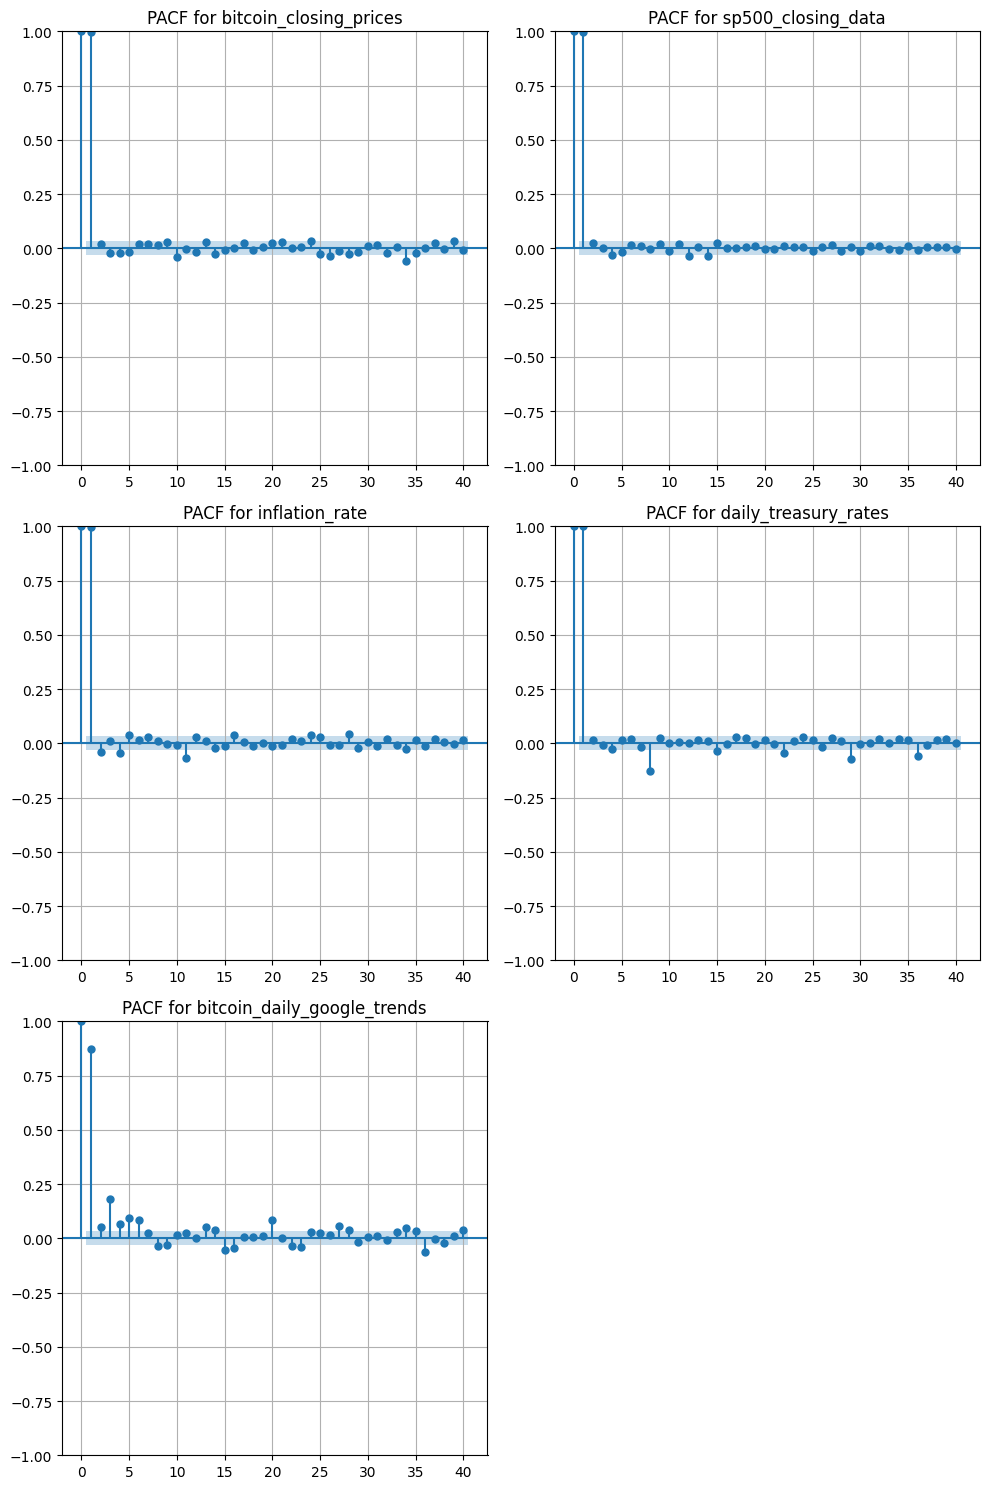

In [31]:
# Set figure size and grid layout
n_cols = 2
n_rows = (len(variables) + 1) // 2  # Calculate rows needed for the grid
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(10, 5 * n_rows))

# Flatten the axes array for easy indexing (handles cases where n_rows = 1)
axes = axes.flatten()

# Plot PACF for each variable
for i, col in enumerate(variables):
        
    # Create PACF plot with valid lag range
    plot_pacf(df[col].dropna(), lags=40, ax=axes[i], method='ywmle', title=f"PACF for {col}")
    axes[i].grid(True)

# Remove any unused subplots (if variables < n_rows * n_cols)
for j in range(len(variables), len(axes)):
    fig.delaxes(axes[j])

# Adjust layout for clarity
plt.tight_layout()
plt.show()

In [32]:
# Initialize an empty list to store results
adf_results = {}

# Loop through each variable in the DataFrame
for col in variables:
    # Perform Dickey-Fuller test
    dftest = adfuller(df[col], autolag='AIC')

    # Collect all the results from the ADF test
    adf_results[col] = {
        'Test Stats': dftest[0],  # ADF Test Statistic
        'p-value': dftest[1],  # p-value of the test
        'Number of Lags': dftest[2],  # Number of lags used in the test
        'Number of Used Observations': dftest[3],  # Number of observations used
        'Critical Value (1%)': dftest[4]['1%'],  # Critical value for 1% significance level
        'Critical Value (5%)': dftest[4]['5%'],  # Critical value for 5% significance level
        'Critical Value (10%)': dftest[4]['10%'],  # Critical value for 10% significance level
        'H0 Decision': 'Reject' if dftest[1] < 0.05 else 'Accept',  # H0 decision based on p-value
        'Stationary': 'Yes' if dftest[1] < 0.05 else 'No'  # Stationarity based on p-value
    }

# Convert the dictionary into a DataFrame
adf_results_df = pd.DataFrame(adf_results)

# Display the result table
print(adf_results_df)

                            bitcoin_closing_prices sp500_closing_data inflation_rate daily_treasury_rates bitcoin_daily_google_trends
Test Stats                        -0.618348             0.368779        -1.988891         -0.282852                -6.015863         
p-value                            0.866782             0.980289         0.291465          0.927898                      0.0         
Number of Lags                           28                   14               15                29                       27         
Number of Used Observations            3626                 3640             3639              3625                     3627         
Critical Value (1%)               -3.432155            -3.432148        -3.432148         -3.432155                -3.432154         
Critical Value (5%)               -2.862337            -2.862334        -2.862335         -2.862338                -2.862337         
Critical Value (10%)              -2.567194            -2.5671

`adf_results_df` contains the results of the Dickey-Fuller test for each variable. It includes the following columns:

- **Test Stats**: The ADF test statistic.
- **p-value**: The p-value of the test.
- **Number of Lags**: The number of lags used in the test.
- **Number of Used Observations**: The number of observations used.
- **Critical Value (1%)**: The critical value for a 1% significance level.
- **Critical Value (5%)**: The critical value for a 5% significance level.
- **Critical Value (10%)**: The critical value for a 10% significance level.
- **H0 Decision**: The decision based on the p-value. If the p-value is less than 0.05, the null hypothesis is rejected, indicating that the time series is non-stationary.
- **Stationary**: The stationarity of the time series based on the p-value. If the p-value is less than 0.05, the time series is considered stationary.

In order to make the data stationary, we need to transform the data. We can do this using the `statsmodels` library. This is done in feature engineering.

In [33]:
# Initialize an empty list to store results
kpss_results = {}

# Loop through each variable in the DataFrame
for col in variables:
    # Perform KPSS test
    kpsstest = kpss(df[col], regression='c', nlags='auto')  # 'c' for level stationarity

    # Collect all the results from the KPSS test
    kpss_results[col] = {
        'Test Stats': kpsstest[0],  # KPSS Test Statistic
        'p-value': kpsstest[1],  # p-value of the test
        'Number of Lags': kpsstest[2],  # Number of lags used in the test
        'Critical Value (10%)': kpsstest[3]['10%'],  # Critical value for 10% significance level
        'Critical Value (5%)': kpsstest[3]['5%'],  # Critical value for 5% significance level
        'Critical Value (1%)': kpsstest[3]['1%'],  # Critical value for 1% significance level
        'H0 Decision': 'Reject' if kpsstest[1] < 0.05 else 'Accept',  # H0 decision based on p-value
        'Stationary': 'No' if kpsstest[1] < 0.05 else 'Yes'  # Stationarity based on p-value
    }

# Convert the dictionary into a DataFrame
kpss_results_df = pd.DataFrame(kpss_results)

# Display the result table
print(kpss_results_df)

                     bitcoin_closing_prices sp500_closing_data inflation_rate daily_treasury_rates bitcoin_daily_google_trends
Test Stats                  6.581981             8.700938         4.354018          4.628924                 0.248662         
p-value                         0.01                 0.01             0.01              0.01                      0.1         
Number of Lags                    38                   38               38                38                       36         
Critical Value (10%)           0.347                0.347            0.347             0.347                    0.347         
Critical Value (5%)            0.463                0.463            0.463             0.463                    0.463         
Critical Value (1%)            0.739                0.739            0.739             0.739                    0.739         
H0 Decision                   Reject               Reject           Reject            Reject                   

`kpss_results_df` contains the results of the KPSS test for each variable. It includes the following columns:

- **Test Stats**: The KPSS test statistic.
- **p-value**: The p-value of the test.
- **Number of Lags**: The number of lags used in the test.
- **Critical Value (10%)**: The critical value for a 10% significance level.
- **Critical Value (5%)**: The critical value for a 5% significance level.
- **Critical Value (1%)**: The critical value for a 1% significance level.
- **H0 Decision**: The decision based on the p-value. If the p-value is less than 0.05, the null hypothesis is rejected, indicating that the time series is non-stationary.
- **Stationary**: The stationarity of the time series based on the p-value. If the p-value is less than 0.05, the time series is considered non-stationary.

In [35]:
import os
print(os.getcwd())  # This prints the current working directory
df.to_csv('cleaned_data.csv', index=False)

d:\Advance-Time-Series-Prediction-W24\1_DatasetCharacteristics
